## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
# Блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Примечание: Ни разу до этого не использовал Ridge и Lasso, но мне показалось, что их особенности хорошо подойдут к данной задаче
# Если я верно понял, они помогают избирательно подходить к признакам, особенно если они коррелируют друг с другом,
# что в наших данных будет актуально
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Вспомогательное
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Дополнительное
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

# Оценки
from sklearn.metrics import mean_squared_error as mse, make_scorer

In [2]:
# Вспомогательные константы
RANDOM_STATE = 12345
DATASET = '/datasets/taxi.csv'

In [3]:
# Взглянем на данные
df = pd.read_csv(DATASET)
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# 1. Сделаем индексом поле с датами
# 2. Сразу разберем его как дату
del df
df = pd.read_csv(DATASET, index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Проверим, что индекс монотонный
df.index.is_monotonic

True

In [6]:
# Выполним ресемплирование по одному часу
df_resampled = df.resample('1H').sum()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## Промежуточный вывод

    Поскольку данные не требуют подготовки, многословным быть не получится. В целом, мы загрузили наш DF, создали DateTimeIndex убедились в монотонности данных и провели ресемплирование по одному часу. Теперь мы готовы к дальнейшему анализу.

# 2. Анализ

In [7]:
# Посмотрим границы наших данных
df_resampled.index.min()

Timestamp('2018-03-01 00:00:00')

In [8]:
df_resampled.index.max()

Timestamp('2018-08-31 23:00:00')

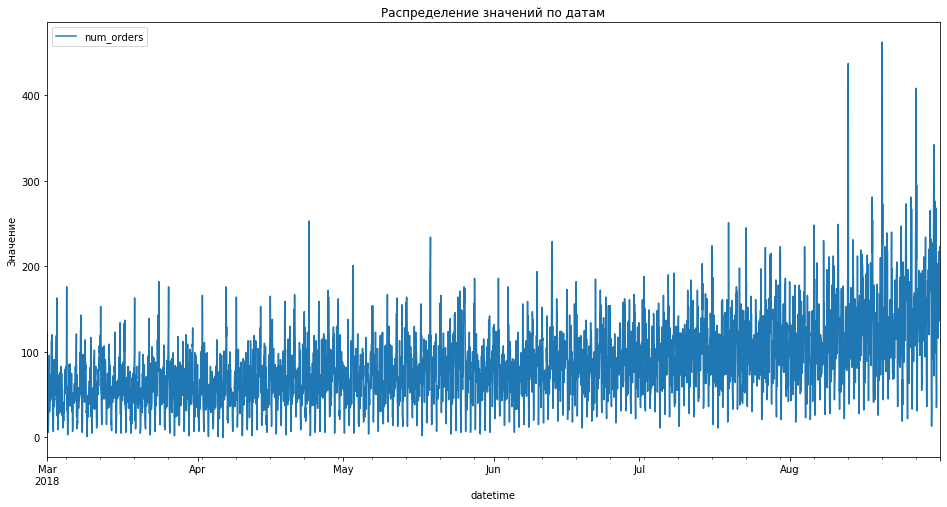

In [9]:
# Посмотрим график
def make_full_size_plot(data):
    fig, ax = plt.subplots(1)
    ax.set_title('Распределение значений по датам')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Значение')
    data.plot(figsize=(16,8), ax=ax)
    
make_full_size_plot(df_resampled)

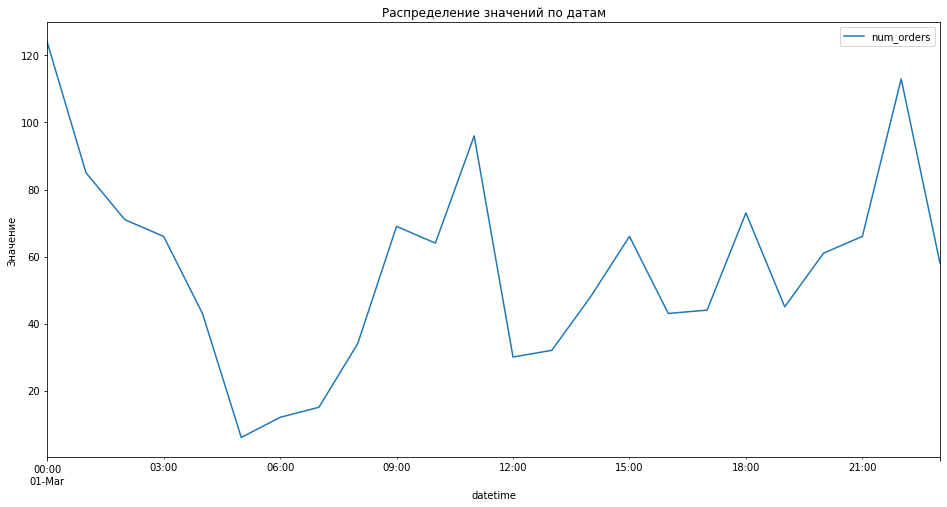

In [10]:
# Попробуем меньшие размерности, посмотрим день
make_full_size_plot(df_resampled.head(24))

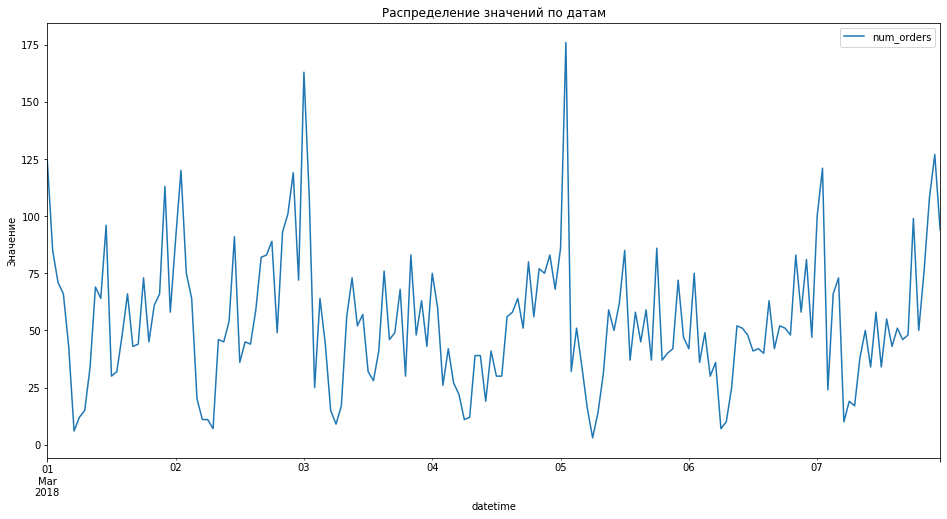

In [11]:
# Неделя
make_full_size_plot(df_resampled.head(24 * 7))

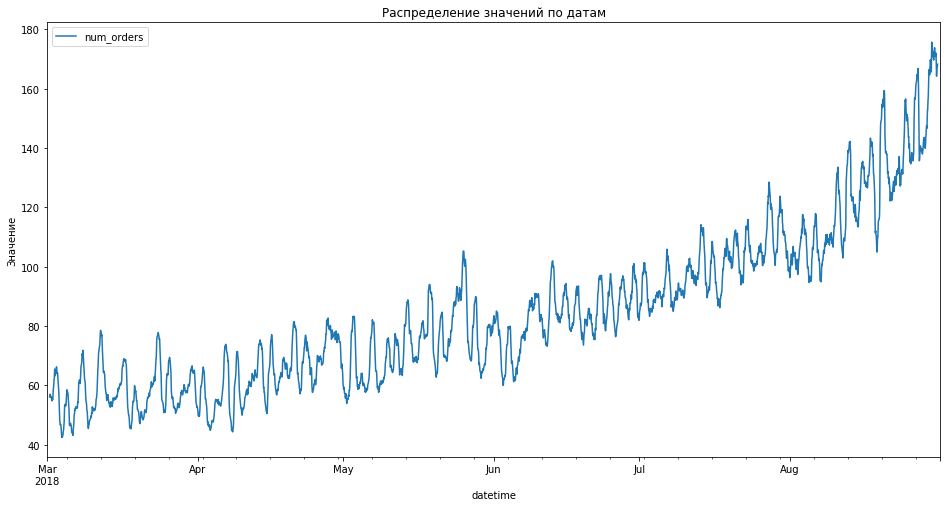

In [12]:
# Разложение временного ряда на тренд, сезонность и остаток
df_resampled_decomposed = seasonal_decompose(df_resampled)
# Тренд
make_full_size_plot(df_resampled_decomposed.trend)

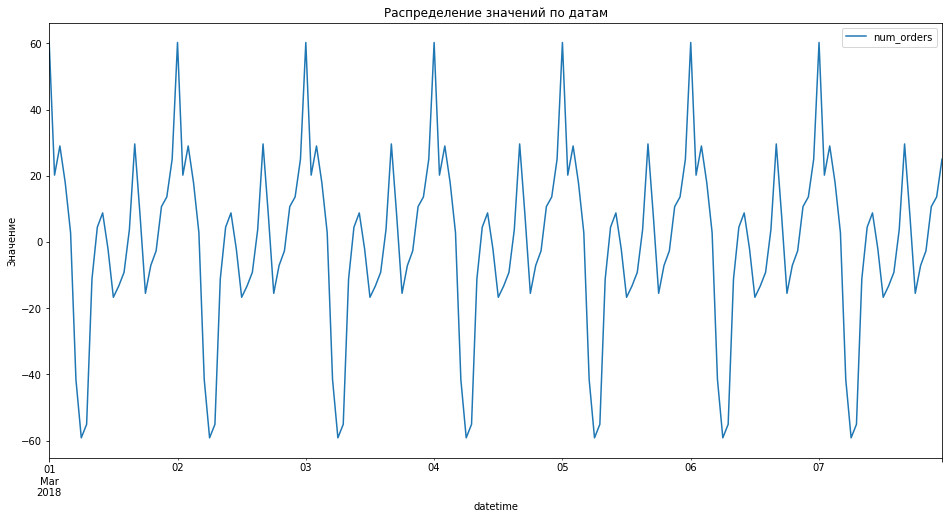

In [13]:
# Сезонность (неделя)
make_full_size_plot(df_resampled_decomposed.seasonal.head(24*7))

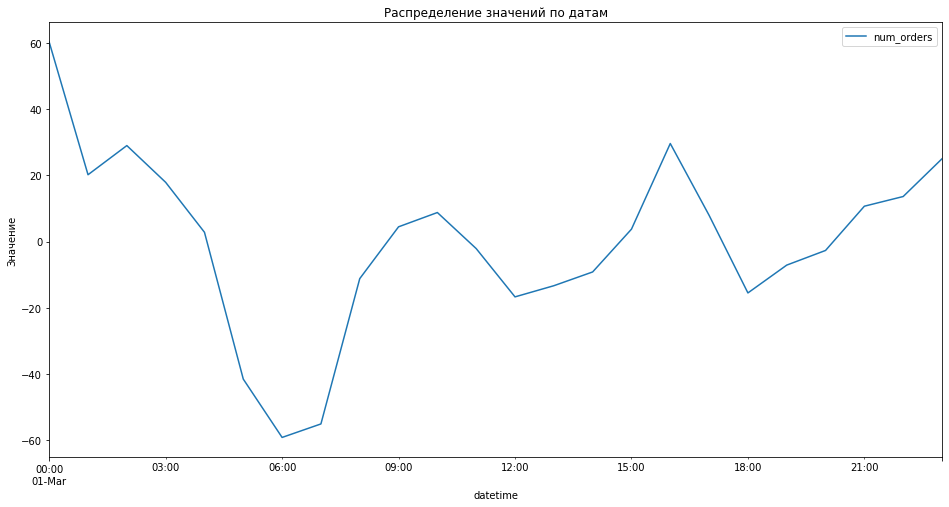

In [14]:
# Сезонность (день)
make_full_size_plot(df_resampled_decomposed.seasonal.head(24))

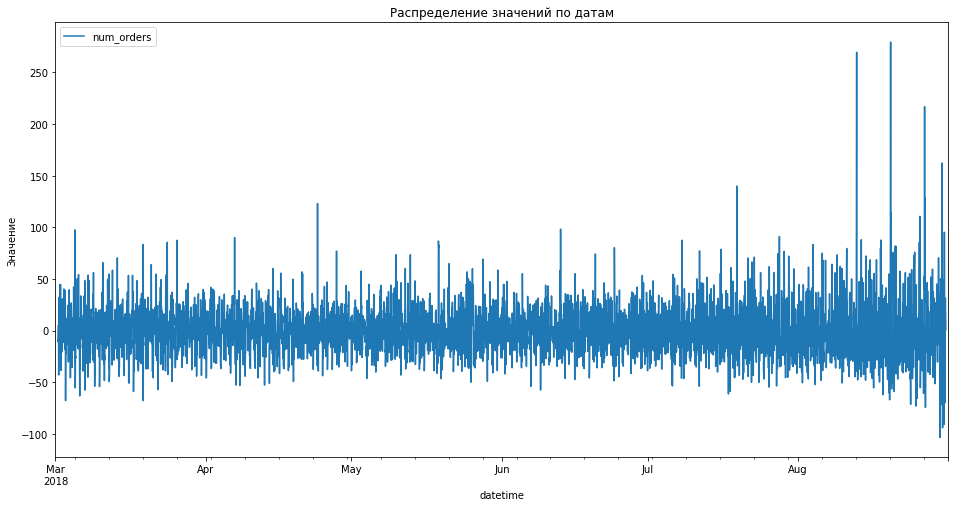

In [15]:
# Остаток
make_full_size_plot(df_resampled_decomposed.resid)

## Промежуточный вывод

    В целом, очевиден восходящий тренд и дневная сезонность. Среди дня самым популярным временем становятся промежуток около полуночи (видимо, когда транспорт перестает ходить), а также очевиден рост в часы пик - 9 утра и 6 вечера, видимо, для опаздывающих на работу или любящих комфорт.
    
    Боюсь, что еще тут можно проанализировать, идей пока нет) Также, как и не ясно, как интерпретировать остаток. Но тут явно количество заказов у нашего Четкого такси растет и при этом растет остаток.

# 3. Обучение

## Подготовка

In [16]:
# Определим функцию для рассчета rmse (будем использовать в scoring)
def rmse(predicted, target):
    return mse(predicted, target) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [17]:
# Подготовим признаки
TARGET_NAME = 'num_orders'

def make_features(df, max_lag, rolling_mean_size, use_hour):
    data = df.copy()
    
    # Календарные признаки
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Подглядел в другой работе, мб будет полезным
    if use_hour:
        hour = data.index.hour
        data['hour'] = hour
        data['sin_hour'] = np.sin(2 * np.pi * hour / 24)
        data['cos_hour'] = np.cos(2 * np.pi * data.index.hour / 24)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[TARGET_NAME].shift(lag)

    data['rolling_mean'] = data[TARGET_NAME].shift().rolling(rolling_mean_size).mean()
    
    return data

In [18]:
# Поскольку мы сами будем формировать признаки, есть смысл создать несколько наборов с различными параметрами
# Проверять все будем на линейной регрессии, таким образом мы отберем признаки, которые покажут себя лучше всего
# и уже на них будем проверять все остальные модели

# Возможно, есть готовый способ сделать это, тогда просьба ревьюверу поделиться им

features_search_result = []

for max_lag in range(10, 41, 10):
    for rolling_mean_size in (6, 19, 6):
        for use_hour in range(2):
            features = make_features(df_resampled, max_lag, rolling_mean_size, bool(use_hour))
            train, test = train_test_split(features, shuffle=False, test_size=0.1)
            
            train = train.dropna()
            
            train_target = train[TARGET_NAME]
            train_features = train.drop(columns=[TARGET_NAME])
            test_target = test[TARGET_NAME]
            test_features = test.drop(columns=[TARGET_NAME])
            
            model = LinearRegression()
            model.fit(train_features.dropna(), train_target.dropna())
            test_predicted = model.predict(test_features)
            
            tmp_result = dict()
            tmp_result['max_lag'] = max_lag
            tmp_result['rolling_mean_size'] = rolling_mean_size
            tmp_result['use_hour'] = use_hour
            tmp_result['rmse'] = rmse(test_predicted, test_target)
            
            features_search_result.append(tmp_result)

In [19]:
# Найдем лучший вариант
min_rmse_row = dict();
min_rmse_row['rmse'] = 100;

for row in features_search_result:
    if (row['rmse'] < min_rmse_row['rmse']):
        min_row_rmse = row

# Посмотрим, что получилось:
min_row_rmse

{'max_lag': 40,
 'rolling_mean_size': 6,
 'use_hour': 1,
 'rmse': 43.911509193986234}

In [20]:
# Итого, DF, с которым будем работать:
features = make_features(df_resampled, min_row_rmse['max_lag'],  min_row_rmse['rolling_mean_size'], min_row_rmse['use_hour'])
train, test = train_test_split(features, shuffle=False, test_size=0.1)
train = train.dropna()

train_target = train[TARGET_NAME]
train_features = train.drop(columns=[TARGET_NAME])
test_target = test[TARGET_NAME]
test_features = test.drop(columns=[TARGET_NAME])

In [21]:
# Чтобы не собирать вручную результаты, напишем класс, который будет сохранять время обучения, время предсказания и RMSE

import time

class ModelHelper:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [22]:
# Создадим переменную, где будут храниться результаты
    
result = []

# И создадим функцию для вывода по красоте
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

In [23]:
# Определим разбитие для всех методов
ts_cv = TimeSeriesSplit(n_splits=2)

## Случайный лес

    Ремарка: дерево решений еще ни разу не показало лучший результат, поэтому проверять на нем не будем

In [24]:
# Подберем параметры

parameters = {'n_estimators': range(10,101,20),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model = RandomForestRegressor(random_state=RANDOM_STATE)
grid = GridSearchCV(model, parameters, cv=ts_cv, scoring='neg_mean_squared_error')
grid.fit(train_features, train_target)

grid.best_params_

# Для отладки - 
# {'max_depth': 7,
# 'min_samples_leaf': 3,
# 'min_samples_split': 2,
# 'n_estimators': 90}

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 90}

In [26]:
# Проверим наш случайный лес
model_forest = RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=90, random_state=RANDOM_STATE)
model_forest_helper = ModelHelper('Random forest', model_forest)
model_forest_helper.fit(train_features, train_target)
model_forest_helper.predict(test_features, test_target)
result.append(model_forest_helper.getResult())

## Бустинг

### LGBMRegressor

In [27]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE)
gbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=ts_cv, scoring='neg_mean_squared_error')
grid_gbm.fit(train_features, train_target);

grid_gbm.best_params_

# Для отладки - {'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 20}

CPU times: user 1min 14s, sys: 776 ms, total: 1min 15s
Wall time: 1min 16s


{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}

In [28]:
# Посмотрим, что получилось в итоге
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(train_features, train_target)
model_gbm_helper.predict(test_features, test_target)
result.append(model_gbm_helper.getResult())

### CatBoost

In [29]:
%%time

cbr = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=RANDOM_STATE)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=ts_cv, scoring='neg_mean_squared_error')
grid_cbr.fit(train_features, train_target);

grid_cbr.best_params_

# Для отладки {'depth': 7, 'iterations': 40, 'learning_rate': 0.1778279410038923}

CPU times: user 1min 50s, sys: 7.42 s, total: 1min 57s
Wall time: 3min 3s


{'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}

In [30]:
# Посмотрим, что получилось в итоге
model_cbr = grid_cbr.best_estimator_
model_cbr_helper = ModelHelper('CatBoost', model_cbr)
model_cbr_helper.fit(train_features, train_target)
model_cbr_helper.predict(test_features, test_target)
result.append(model_cbr_helper.getResult())

## Регрессии

### Линейная регрессия

In [31]:
# Попробуем линейную регрессию
model_lr = LinearRegression()
model_lr_helper = ModelHelper('Linear regression', model_lr)
model_lr_helper.fit(train_features, train_target)
model_lr_helper.predict(test_features, test_target)
result.append(model_lr_helper.getResult())

### Ridge

In [32]:
model_ridge = Ridge(random_state=RANDOM_STATE)
model_ridge_helper = ModelHelper('Ridge', model_ridge)
model_ridge_helper.fit(train_features, train_target)
model_ridge_helper.predict(test_features, test_target)
result.append(model_ridge_helper.getResult())

### Lasso

In [33]:
model_lasso = Lasso(random_state=RANDOM_STATE)
model_lasso_helper = ModelHelper('Lasso', model_lasso)
model_lasso_helper.fit(train_features, train_target)
model_lasso_helper.predict(test_features, test_target)
result.append(model_lasso_helper.getResult())

# 4. Тестирование

In [34]:
# Посмотрим, что получилось:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           4.85641|           0.01347|    42.16782|
|            LightGBM|           1.59608|           0.10182|    39.47348|
|            CatBoost|           2.36090|           0.00569|    44.18192|
|   Linear regression|           0.00885|           0.01000|    43.91151|
|               Ridge|           0.10179|           0.08683|    43.90825|
|               Lasso|           0.28903|           0.09905|    44.42958|


    Наилучший результат показала LightGBM, правда при худшем времени обучения. Тем не менее, для текущей задачи это не было основным критерием, а значит мы можем остановится на данной модели.

In [35]:
# Вычислим предсказания для графика
model_gbm.fit(train_features, train_target)
test_predicted = model_gbm.predict(test_features)
rmse(test_predicted, test_target)

39.47347867946146

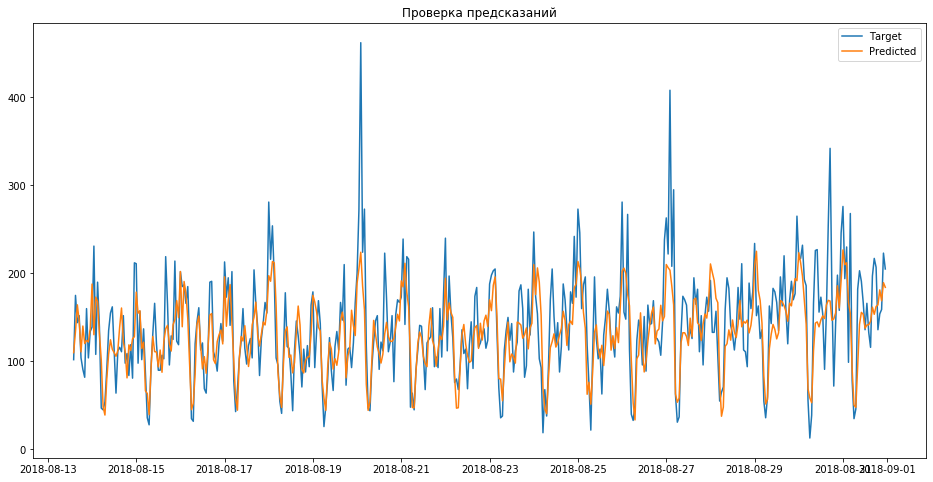

In [36]:
# Покажем предсказания в виде графика
plt.figure(figsize=(16, 8))
plt.plot(test_target, label='Target')
plt.plot(test_target.index, test_predicted, label='Predicted')
plt.title('Проверка предсказаний')
plt.legend()
plt.show()

# Общий вывод

    1. Мы изучили имеющиеся данные и определили тренд и сезонность
    2. Выбрали и подготовили наилучшие признаки для обучения наших моделей
    3. С помощью этих признаков проверили несколько моделей и отобрали лучшую
    4. Проверили наши модели и в несколько раз опередили целевой показатель, получив RMSE 6.83948994336367
    
    Компания "Чётенькое такси" может спать спокойно)